In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [142]:
mesh = 26

In [143]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/xlabels.txt',delim_whitespace=True,header=None)



In [144]:

X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
# X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

           0         1         2         3        4        5         6  \
0    2.77049   5.32910   9.17043   7.23675  5.21731  32.2885  11.74730   
1    3.61746  12.72040  12.80220   8.35094  2.05551  39.2948  10.69220   
2    2.38790   7.65312  14.38840  10.16880  4.06018  28.3848  17.31130   
3    3.76219  21.59860  11.81960   3.56951  2.52663  18.8133  10.60980   
4    0.83687  10.96490   2.71685   3.73192  3.98974  30.5635   5.18740   
..       ...       ...       ...       ...      ...      ...       ...   
195  1.57167  20.55250   4.34630   4.02029  4.08107  32.4084  16.89020   
196  3.87212  31.39530   3.95767   9.41722  3.54334  16.8671  10.51070   
197  1.90693  19.14840   7.64500   4.70468  2.66861  22.9449  19.89110   
198  2.88270  17.37540  14.74540  10.00510  4.58641  27.4414   8.65209   
199  1.07599   4.21971   8.84592   3.88759  2.23291  12.5012  19.51450   

            7         8        9  
0    11.25900  0.013097  1.43362  
1    11.99220  0.004829  1.53001  
2    1

In [145]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/output_mask.txt',index_col=None,delim_whitespace=True,header=None)

In [146]:
np.sum(mask)

0    180
dtype: int64

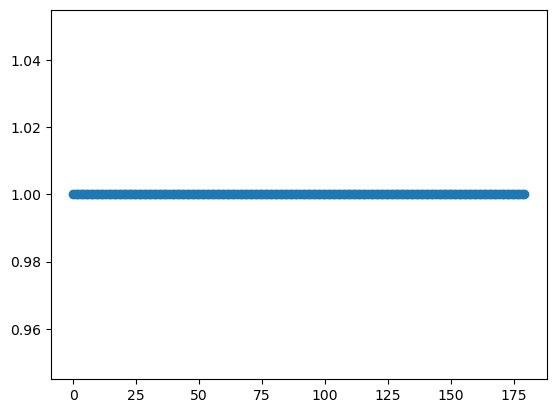

In [147]:
plt.plot(mask,'o')

In [148]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_12/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     $V^{\mathrm{max}}_{\mathrm{LV}}$  $V^{\mathrm{max}}_{\mathrm{RV}}$  \
0                             122.830                           107.011   
1                             119.965                           107.104   
2                             119.311                           104.868   
3                             119.716                           106.103   
4                             134.505                           108.984   
..                                ...                               ...   
175                           123.581                           106.442   
176                           119.882                           106.372   
177                           124.387                           108.271   
178                           122.424                           108.126   
179                           117.937                           106.206   

     $V^{\mathrm{max}}_{\mathrm{LA}}$  $V^{\mathrm{max}}_{\mathrm{RA}}$  \
0                       

In [149]:
input_masked = X_all.copy()

In [150]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_masked=input_masked.iloc[np.array(mask==1),]
y_all=y_all.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [151]:
input_masked.shape

(180, 10)

In [152]:
y_all.shape

(180, 10)

In [153]:
y_all.index[0]

0

In [154]:
y_all

,$V^{\mathrm{max}}_{\mathrm{LV}}$,$V^{\mathrm{max}}_{\mathrm{RV}}$,$V^{\mathrm{max}}_{\mathrm{LA}}$,$V^{\mathrm{max}}_{\mathrm{RA}}$,"$\overline{E_{ff,\mathrm{LV}}}$","$\overline{E_{ff,\mathrm{RV}}}$","$\overline{E_{ff,\mathrm{LA}}}$","$\overline{E_{ff,\mathrm{RA}}}$","$\overline{E_{ff,\mathrm{V}}}$","$\overline{E_{ff,\mathrm{A}}}$"
0,122.830,107.011,52.5534,35.1139,0.013983,0.006642,0.008325,0.001062,0.011840,0.003824
1,119.965,107.104,55.1145,35.9331,0.010084,0.005300,0.017759,0.003667,0.008682,0.009017
2,119.311,104.868,52.1082,34.8203,0.009859,0.004502,0.008142,0.000627,0.008296,0.003486
3,119.716,106.103,53.4493,35.1358,0.009465,0.005277,0.015993,0.001998,0.008246,0.007319
4,134.505,108.984,52.2999,34.9678,0.023855,0.014564,0.009432,0.000815,0.021204,0.004088
...,...,...,...,...,...,...,...,...,...,...
175,123.581,106.442,52.0646,34.7864,0.014663,0.007849,0.008397,0.000492,0.012694,0.003503
176,119.882,106.372,52.6692,35.1894,0.009620,0.005180,0.009379,0.001343,0.008325,0.004399
177,124.387,108.271,53.9427,35.5146,0.015171,0.007479,0.013506,0.002288,0.012922,0.006551
178,122.424,108.126,53.0241,35.2923,0.011077,0.006220,0.010594,0.001786,0.009659,0.005139


In [155]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [156]:
y_train

tensor([[1.2283e+02, 1.0701e+02, 5.2553e+01,  ..., 1.0624e-03, 1.1840e-02,
         3.8239e-03],
        [1.1997e+02, 1.0710e+02, 5.5114e+01,  ..., 3.6673e-03, 8.6821e-03,
         9.0167e-03],
        [1.1931e+02, 1.0487e+02, 5.2108e+01,  ..., 6.2658e-04, 8.2963e-03,
         3.4864e-03],
        ...,
        [1.2439e+02, 1.0827e+02, 5.3943e+01,  ..., 2.2879e-03, 1.2922e-02,
         6.5505e-03],
        [1.2242e+02, 1.0813e+02, 5.3024e+01,  ..., 1.7857e-03, 9.6590e-03,
         5.1391e-03],
        [1.1794e+02, 1.0621e+02, 5.3168e+01,  ..., 1.8783e-03, 6.8586e-03,
         5.0831e-03]], dtype=torch.float64)

In [157]:
x_train.shape

torch.Size([180, 10])

In [158]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9


In [159]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.503218, 4.98092]
[2.00623, 31.9479]
[1.06893, 15.9664]
[0.7678, 11.9495]
[1.50603, 5.99704]
[10.1435, 39.8584]
[5.04584, 19.9778]
[3.76184, 14.9855]
[0.000669586, 0.0499096]
[1.00128, 1.99595]


In [160]:
x_labels=[1,2,3,4,5,6,7,8,9,10]

In [161]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_77097/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [162]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

          ST   ST_conf
1   0.598893  0.080462
2   0.086996  0.013355
3   0.008471  0.001084
4   0.208643  0.026787
5   0.000451  0.000063
6   0.000334  0.000057
7   0.000483  0.000070
8   0.000117  0.000027
9   0.193655  0.032391
10  0.000160  0.000029
          S1   S1_conf
1   0.561118  0.074801
2   0.065279  0.025012
3   0.007867  0.007667
4   0.184613  0.044560
5  -0.000269  0.001931
6  -0.001892  0.001666
7   0.000131  0.002223
8   0.000380  0.001036
9   0.132558  0.047616
10 -0.000044  0.001245
               S2   S2_conf
(1, 2)  -0.017625  0.106003
(1, 3)  -0.018084  0.100639
(1, 4)  -0.017977  0.112972
(1, 5)  -0.020165  0.101535
(1, 6)  -0.018101  0.101312
(1, 7)  -0.018865  0.101325
(1, 8)  -0.020338  0.101543
(1, 9)   0.017771  0.130765
(1, 10) -0.020492  0.101238
(2, 3)  -0.000670  0.035041
(2, 4)   0.012475  0.045814
(2, 5)  -0.000621  0.035162
(2, 6)  -0.000747  0.035233
(2, 7)  -0.001126  0.035061
(2, 8)  -0.000658  0.035192
(2, 9)   0.005730  0.042194
(2, 10) -0.000188 

          ST   ST_conf
1   0.000524  0.000067
2   0.000276  0.000036
3   0.001669  0.000211
4   0.001959  0.000265
5   0.600671  0.060985
6   0.219634  0.023033
7   0.004885  0.000662
8   0.075184  0.009940
9   0.128535  0.013748
10  0.000108  0.000016
          S1   S1_conf
1  -0.000216  0.001945
2  -0.000455  0.001506
3   0.001374  0.003534
4  -0.001137  0.003620
5   0.578519  0.060236
6   0.197825  0.041993
7   0.004178  0.006128
8   0.061586  0.021527
9   0.116311  0.034393
10  0.000003  0.000790
               S2   S2_conf
(1, 2)   0.000312  0.002803
(1, 3)   0.000293  0.002802
(1, 4)   0.000365  0.002786
(1, 5)   0.000209  0.003251
(1, 6)   0.000903  0.002773
(1, 7)   0.000294  0.002779
(1, 8)   0.000080  0.002772
(1, 9)   0.000337  0.002909
(1, 10)  0.000334  0.002799
(2, 3)   0.000595  0.001925
(2, 4)   0.000618  0.001904
(2, 5)   0.000462  0.002797
(2, 6)   0.000693  0.002051
(2, 7)   0.000629  0.001909
(2, 8)   0.000560  0.002129
(2, 9)   0.000730  0.001826
(2, 10)  0.000620 

In [163]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [164]:
# x_labels.values.squeeze().tolist()

In [165]:
y_all.columns.tolist()

['$V^{\\mathrm{max}}_{\\mathrm{LV}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{RV}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{LA}}$',
 '$V^{\\mathrm{max}}_{\\mathrm{RA}}$',
 '$\\overline{E_{ff,\\mathrm{LV}}}$',
 '$\\overline{E_{ff,\\mathrm{RV}}}$',
 '$\\overline{E_{ff,\\mathrm{LA}}}$',
 '$\\overline{E_{ff,\\mathrm{RA}}}$',
 '$\\overline{E_{ff,\\mathrm{V}}}$',
 '$\\overline{E_{ff,\\mathrm{A}}}$']

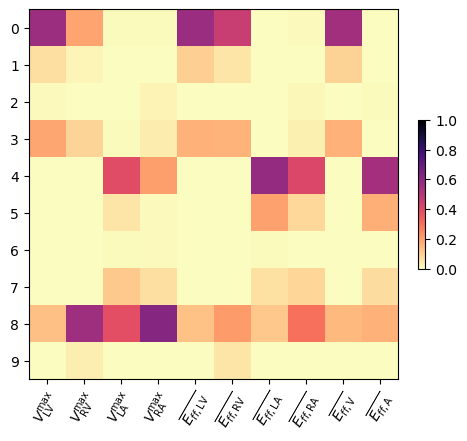

In [166]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

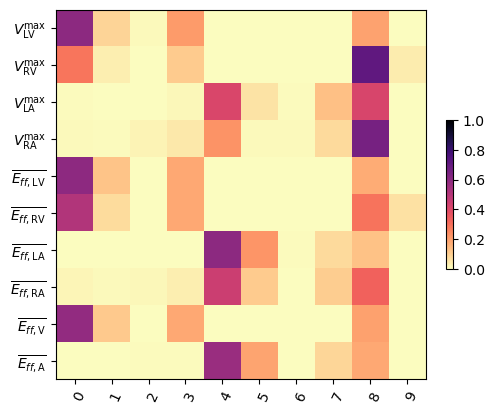

In [167]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [168]:
np.savetxt("Si_total_mech_"+str(mesh)+".csv", Si_total, delimiter=",")
np.savetxt("Si_first_mech_"+str(mesh)+".csv", Si_first, delimiter=",")